# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Loading the Data

In [2]:
df=pd.read_csv('/Users/stefanoshadjiefstathiou/Documents/Datascience/Projects/Credit Card fraud Detection/data/creditcard.csv')
df.shape # rows and columns

(284807, 31)

#  Checking for null values

In [3]:
print(df.isnull().values.sum())
df.isnull().values.any()
 # no null values

0


False

# Exploring the data

In [4]:
print(df.columns)
print(df.dtypes)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')
Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object


# First visual Look of Data in a bar plot

Text(0, 0.5, 'Frequency')

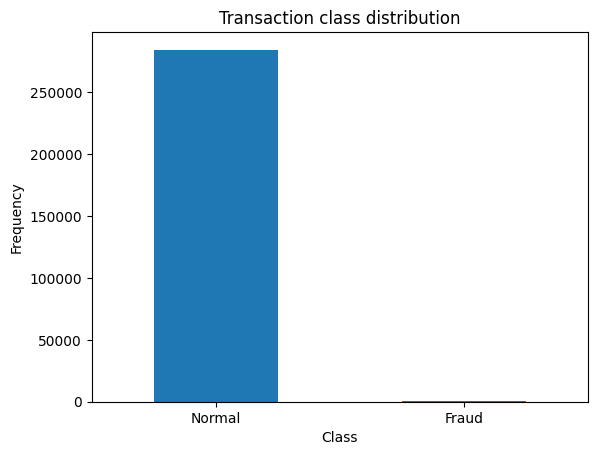

In [5]:
LABELS = ["Normal", "Fraud"]

count_classes = pd.value_counts(df['Class'])
count_classes.plot(kind = 'bar',rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

# Seperate data in Fraud and Normal for further analysis

In [6]:
frauds = df[df.Class == 1]
print(frauds.shape)

normal = df[df.Class == 0]
print(normal.shape)

(492, 31)
(284315, 31)


# Describing

In [7]:
print(frauds.Amount.describe())
print(normal.Amount.describe())

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64


# Amount of money per Class


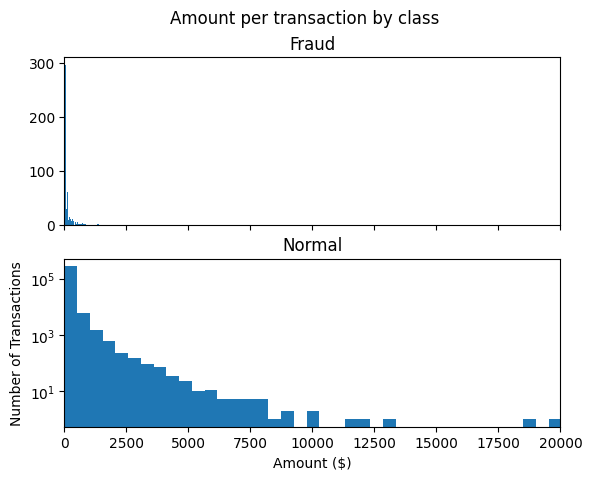

In [8]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show()

# Time of occurance for each class

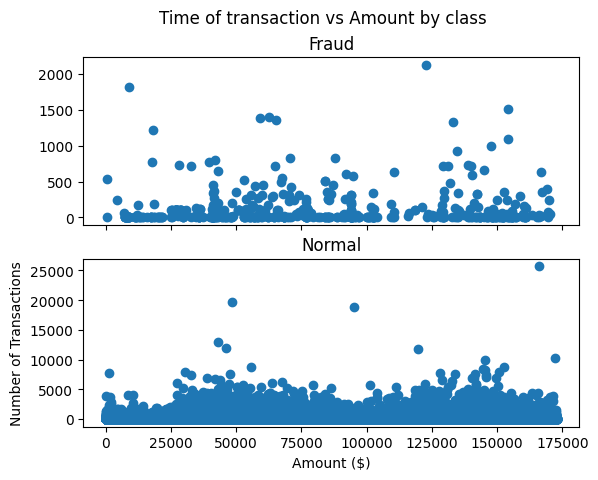

In [9]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')


ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.show()

# Autoencoders

## Preparing the data


In [10]:
from sklearn.preprocessing import StandardScaler

#remove time column
data = df.drop(['Time'], axis=1) # drop the time column
#scaling the amount column and reshaping
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))


## Splitting and reforming data

In [11]:
from sklearn.model_selection import train_test_split
RANDOM_SEED=42

#Splitting data 
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)

#X_train -> removing fraud and then remove column class
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

# y_test = x_stes['class'] and X_test remove class column
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

#Finally keeping only the values from the data X_test, X_train
X_train = X_train.values
X_test = X_test.values

X_train.shape

(227451, 29)

## Building the model

## Creating Lyers

In [12]:
from keras.layers import Input, Dense
from keras import regularizers
from keras.models import Model, load_model

# input dimensions is the number of
#columns in the train data
input_dim = X_train.shape[1]
encoding_dim = 14
#                          29
input_layer = Input(shape=(input_dim, ))

# 2 layers for encoding and 2 layers for decoding

#                 14
encoder = Dense(encoding_dim, activation="tanh",
                activity_regularizer=regularizers.l1(10e-5))(input_layer)

#                        7
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

#                           7
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)

#                29
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)



# Building model exporting best model,history

In [14]:
import tensorflow as tf
from scipy import stats
from keras.callbacks import ModelCheckpoint, TensorBoard
import pickle

nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['accuracy'])


checkpointer = ModelCheckpoint(filepath="/Users/stefanoshadjiefstathiou/Documents/Datascience/Projects/Credit Card fraud Detection/model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='/Users/stefanoshadjiefstathiou/Documents/Datascience/Projects/Credit Card fraud Detection/logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/100


2023-04-06 16:11:57.135850: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


7108/7108 [==============================] - 6s 843us/step - loss: 0.8286 - accuracy: 0.5697 - val_loss: 0.8071 - val_accuracy: 0.6226
Epoch 2/100
7108/7108 [==============================] - 6s 812us/step - loss: 0.7656 - accuracy: 0.6375 - val_loss: 0.7762 - val_accuracy: 0.6687
Epoch 3/100
7108/7108 [==============================] - 6s 820us/step - loss: 0.7344 - accuracy: 0.6794 - val_loss: 0.7612 - val_accuracy: 0.6775
Epoch 4/100
7108/7108 [==============================] - 6s 822us/step - loss: 0.7252 - accuracy: 0.6883 - val_loss: 0.7566 - val_accuracy: 0.6879
Epoch 5/100
7108/7108 [==============================] - 6s 820us/step - loss: 0.7211 - accuracy: 0.6906 - val_loss: 0.7554 - val_accuracy: 0.6913
Epoch 6/100
7108/7108 [==============================] - 6s 838us/step - loss: 0.7181 - accuracy: 0.6938 - val_loss: 0.7506 - val_accuracy: 0.6946
Epoch 7/100
7108/7108 [==============================] - 6s 824us/step - loss: 0.7146 - accuracy: 0.6941 - val_loss: 0.7505 - val_

# Evaluation

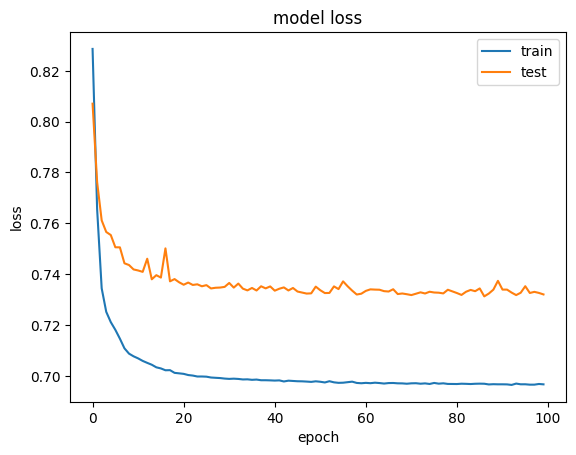

In [16]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')